# Vision Transformer in PyTorch
## DS4440: Practical Neural Networks Final Project

Written by Michael Wheeler, December 2020

Original implementation available [here](https://github.com/google-research/vision_transformer).


In [1]:
import csv
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision

from datetime import datetime
from PIL import Image
from sklearn.metrics import accuracy_score

Definitions for model training utility functions.

In [2]:
# Taken from the in-class exercise on 2020-10-15 covering image classification with CNNs
def train_model(optimizer, model, train_loader, device, epochs=5):
    # Switch to train
    model.train()

    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # forwards
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backwards
            optimizer.zero_grad()
            loss.backward()

            # update params
            optimizer.step()

            epoch_losses.append(loss.item())
        
        losses.append(epoch_losses)
            
    return losses


# Taken from the in-class exercise on 2020-10-15 covering image classification with CNNs
def test_model(model, test_loader, device):
    # Switch to evaluation
    model.eval()

    y, y_hat = [], []

    with torch.no_grad():
        for X_i, y_i in test_loader:
            X_i, y_i = X_i.to(device), y_i.to(device)
            y_hat_i = model(X_i)
            y.extend(y_i.detach().cpu().tolist())
            discrete_preds = y_hat_i.argmax(dim=1).detach().cpu()
            y_hat.extend(discrete_preds)

    return y, y_hat


def save_image_from_array(img, path, mode="RGB"):
    img = Image.fromarray(img, mode)
    img.save(path)

Definition of the Vision Transformer class itself.

In [3]:
class VisionTransformer(torch.nn.Module):
    """PyTorch implementation of the algorithm described in 'An Image is Worth 16x16 Words: Transformers for Image
       Recognition At Scale' by Dosovitskiy et al.

       Original implementation is available here: https://github.com/google-research/vision_transformer
       """

    def __init__(self, h, w, c, num_classes, device="cpu"):
        super().__init__()

        self.device = device

        # Data dimensions
        self.H = h  # Height of an image in pixels
        self.W = w  # Width of an image in pixels
        self.C = c  # Number of channels of the image (e.g. RGB=3)
        self.num_classes = num_classes  # Number of possible classes in the output data

        # Model parameters
        # See Table 1 of Dosovitsky et al. for other options
        self.image_patch_size = 4  # Patch resolution
        self.num_patches = int((self.H * self.W) / (self.image_patch_size ** 2))  # Check N
        self.transformer_hidden_size = 288  # Embedding dimensions throughout the Transformer
        self.transformer_num_layers = 12  # Number of Transformer encoder layers
        self.transformer_num_heads = 12  # Number of heads for multi-headed self attention in the Transformer
        self.transformer_MLP_size = 512  # dimension of feed-forward layer in the Transformer
        self.transformer_activation = "gelu"
        self.dropout_prob = 0.1

        # Model layers
        # Patching and embedding: Done at once in the original implementation
        self.patch_embedding_layer = torch.nn.Conv2d(in_channels=self.C, out_channels=self.transformer_hidden_size,
                                                     kernel_size=(self.image_patch_size, self.image_patch_size),
                                                     stride=(self.image_patch_size, self.image_patch_size))

        # Position embedding layer
        self.position_embedding_layer = torch.nn.Embedding(num_embeddings=self.num_patches+1,
                                                           embedding_dim=self.transformer_hidden_size)

        # Transformer itself: out-of-the-box this isn't structured exactly like the original ViT implementation
        # Specifically the application of LayerNorm happens after MSA/MLP (as in Vaswani et al.) instead of before
        self.encoder_layer = torch.nn.TransformerEncoderLayer(d_model=self.transformer_hidden_size,
                                                              nhead=self.transformer_num_heads, dropout=self.dropout_prob,
                                                              dim_feedforward=self.transformer_MLP_size,
                                                              activation=self.transformer_activation)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer=self.encoder_layer,
                                                   num_layers=self.transformer_num_layers)

        # The final classification head: "one hidden layer at pre-training time, linear layer only at fine-tuning time"
        self.classification_head = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.transformer_hidden_size, out_features=self.transformer_hidden_size),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=self.transformer_hidden_size, out_features=self.num_classes),
            torch.nn.Softmax(dim=2),
        )

    def forward(self, x):
        batch_size = x.shape[0]

        # Patch the images, flatten, and linearly embed: all in one step!
        x_patches = self.patch_embedding_layer(x)
        # Flatten down to a list of patches instead of a grid
        x_patches = x_patches.flatten(start_dim=2)
        assert x_patches.shape[2] == self.num_patches

        # Zero initialize a class token Tensor
        class_token = torch.zeros(*(1, self.transformer_hidden_size, 1),
                                  device=self.device)
        class_token = class_token.repeat(*(batch_size, 1, 1))
        # Concatenate to the beginning of the patch sequence
        x_patches_with_class = torch.cat((class_token, x_patches), dim=2)
        assert x_patches_with_class.shape[2] == self.num_patches + 1

        # Add position embeddings to the sequence
        position_embeddings = self.position_embedding_layer(torch.arange(end=self.num_patches+1, device=self.device))
        position_embeddings = torch.transpose(*(position_embeddings, 0, 1))
        x_patches_with_class_and_posn = x_patches_with_class + position_embeddings
        assert x_patches_with_class_and_posn.shape[1] == self.transformer_hidden_size

        # Pass the data through the Transformer encoder
        x_patches_with_class_and_posn = x_patches_with_class_and_posn.permute(*(2, 0, 1))
        transformer_out = self.encoder(x_patches_with_class_and_posn)

        # Take from the Transformer's output the learned class token only
        transformer_out_class_token = transformer_out[0, :, :].unsqueeze(0)

        # Note: Since we're using PyTorch's built-in Transformer encoder an additional LayerNorm is not necessary here
        # Pass it through the classification head
        out = self.classification_head(transformer_out_class_token)
        assert out.shape[2] == 10
        return torch.squeeze(out)

Definition of the baseline CNN as a point of comparison.

In [4]:
class BaselineCNN(torch.nn.Module):
    """Adapted from the example code at this PyTorch tutorial using CIFAR-10:
       https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
       """

    def __init__(self, h, w, c, num_classes, device="cpu"):
        super().__init__()

        self.device = device

        # Data dimensions
        self.H = h  # Height of an image in pixels
        self.W = w  # Width of an image in pixels
        self.C = c  # Number of channels of the image (e.g. RGB=3)
        self.num_classes = num_classes  # Number of possible classes in the output data

        self.conv_1 = torch.nn.Conv2d(in_channels=self.C, out_channels=6, kernel_size=8)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.conv_2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.linear_1 = torch.nn.Linear(in_features=16 * 4 * 4, out_features=128)
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=64)
        self.linear_3 = torch.nn.Linear(in_features=64, out_features=self.num_classes)

    def forward(self, x):
        x = self.pool_1(F.relu(self.conv_1(x)))
        x = self.pool_2(F.relu(self.conv_2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = F.softmax(self.linear_3(x))
        return x

Set up model training hyperparameters:

In [5]:
# Global parameters
this_device = "cpu"
num_epochs = 500
batch_size = 512
adam_learning_rate = 0.00015
adam_betas = (0.9, 0.999)
criterion = torch.nn.CrossEntropyLoss()

Load the CIFAR-10 data:

In [6]:
# Load CIFAR-10
cifar10_train_dataset = torchvision.datasets.CIFAR10(root="./data",
                                                     train=True, download=True,
                                                     transform=torchvision.transforms.ToTensor())
cifar10_test_dataset = torchvision.datasets.CIFAR10(root="./data",
                                                    train=False, download=True,
                                                    transform=torchvision.transforms.ToTensor())

# Make data loaders
cifar10_train_data_loader = torch.utils.data.DataLoader(cifar10_train_dataset, 
                                                        batch_size=batch_size, 
                                                        shuffle=True)
cifar10_test_data_loader = torch.utils.data.DataLoader(cifar10_test_dataset, 
                                                       batch_size=batch_size, 
                                                       shuffle=True)

# Get image resolution, num channels
assert cifar10_train_dataset.data.shape[1:] == cifar10_test_dataset.data.shape[1:], \
    "Train and test image dimensions don't match!"
N, H, W, C = cifar10_train_dataset.data.shape
assert len(cifar10_train_dataset.classes) == len(cifar10_test_dataset.classes), \
    "Train and test number of classes don't match!"  # Sanity check but not strictly necessary
cifar10_num_classes = len(cifar10_train_dataset.classes)

Files already downloaded and verified
Files already downloaded and verified


Initialize the model objects:

In [7]:
ViT_model = VisionTransformer(h=H, w=W, c=C, num_classes=cifar10_num_classes, device=this_device)
ViT_model.to(ViT_model.device)
ViT_optimizer = torch.optim.Adam(params=ViT_model.parameters(), lr=adam_learning_rate, betas=adam_betas)
print(f'Number of parameters in ViT: {sum(p.numel() for p in ViT_model.parameters() if p.requires_grad)}')

baseline_model = BaselineCNN(h=H, w=W, c=C, num_classes=cifar10_num_classes, device=this_device)
baseline_model.to(baseline_model.device)
baseline_optimizer = torch.optim.Adam(params=baseline_model.parameters(), lr=adam_learning_rate, betas=adam_betas)
print(f'Number of parameters in baseline CNN: {sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)}')

Number of parameters in ViT: 8306250
Number of parameters in baseline CNN: 44512


Set up an experiment to evaluate improvement of test set top-1 accuracy over the course of model training.

In [ ]:
def perform_test_over_epochs_experiment(model, optimizer, name, eval_freq=5):
    training_losses = []
    test_performance_over_epochs = {}

    with open(f'{name}_test_set_accuracy_over_epochs.csv', "w") as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(["Epoch", "Test Set Accuracy"])

    for epoch in range(1, num_epochs+1):
        print(f'Begin Epoch {epoch}: {datetime.now()}')
        training_losses += train_model(optimizer, model,
                                       cifar10_train_data_loader, this_device,
                                       epochs=1)

        if epoch % eval_freq == 0:
            y, y_hat = test_model(model, cifar10_test_data_loader, this_device)
            test_accuracy = accuracy_score(y, y_hat)

            print(f'Test accuracy at epoch {epoch}: {round(test_accuracy, 4)}')
            test_performance_over_epochs[epoch] = test_accuracy

            # Export the results of the experiment as we go
            with open(f'{name}_test_set_accuracy_over_epochs.csv', "a") as f:
                csv_writer = csv.writer(f)
                csv_writer.writerow([epoch, test_accuracy])

    return training_losses, test_performance_over_epochs

Train and evaluate the baseline model:

In [ ]:
baseline_results = perform_test_over_epochs_experiment(baseline_model, baseline_optimizer, name="baseline")

Train and evaluate the ViT model:

In [ ]:
ViT_results = perform_test_over_epochs_experiment(ViT_model, ViT_optimizer, name="ViT")

Produce a plot of test-set performance over epochs for each model:
(I switched from CoLab to desktop here, hence the config import and slightly different path)

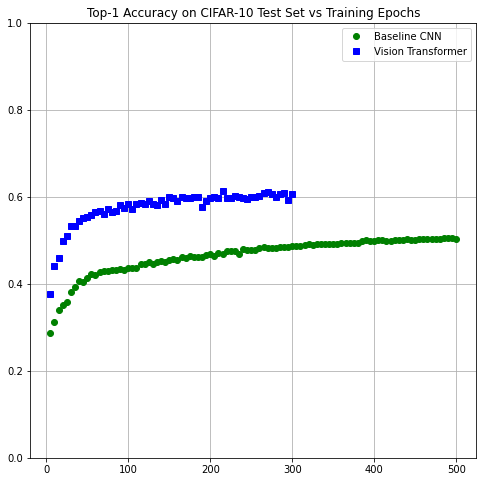

In [11]:
import config

baseline_epochs = []
baseline_test_acc = []
ViT_epochs = []
ViT_test_acc = []

with open(config.BASE_DIR / "data" / "baseline_test_set_accuracy_over_epochs.csv", "r") as baseline_f, \
    open(config.BASE_DIR / "data" / "ViT_test_set_accuracy_over_epochs.csv", "r") as ViT_f:

    baseline_reader = csv.reader(baseline_f)
    next(baseline_reader)
    for epoch, test_acc in baseline_reader:
        baseline_epochs.append(int(float(epoch)))
        baseline_test_acc.append(float(test_acc))

    ViT_reader = csv.reader(ViT_f)
    next(ViT_reader)
    for epoch, test_acc in ViT_reader:
        ViT_epochs.append(int(float(epoch)))
        ViT_test_acc.append(float(test_acc))


# https://stackoverflow.com/a/41717533/8857601
plt.rcParams["figure.figsize"] = (8, 8)
plt.ylim(0, 1)
plt.grid(b=True, axis='both')

baseline_line = plt.plot(baseline_epochs, baseline_test_acc, 'go', label="Baseline CNN")
ViT_line = plt.plot(ViT_epochs, ViT_test_acc, 'bs', label="Vision Transformer")
plt.title("Top-1 Accuracy on CIFAR-10 Test Set vs Training Epochs")
plt.legend()
plt.savefig(config.BASE_DIR / "test_acc_vs_epochs.png")
plt.show()
